In [1]:
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from collections import Counter
import torch
from torch import optim
import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
import os
import numpy as np
from PIL import Image
from torchvision import transforms

class UECFoodPixDataset(Dataset):
    def __init__(self, img_dir, mask_dir, file_list, category_file, transform=None, mask_transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform

        # 加载图像列表
        with open(file_list, 'r') as f:
            self.image_ids = [line.strip() for line in f]

        # 加载类别信息
        self.categories = self.load_categories(category_file)

    def load_categories(self, category_file):
        categories = {}
        with open(category_file, 'r') as f:
            next(f)  # 跳过文件头
            for line in f.readlines():
                parts = line.strip().split()
                if len(parts) > 1:
                    categories[int(parts[0])] = parts[1]
        return categories

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, f"{self.image_ids[idx]}.jpg")
        mask_name = os.path.join(self.mask_dir, f"{self.image_ids[idx]}.png")

        # 确保图像和掩码都存在
        try:
            image = Image.open(img_name).convert("RGB")

            # 提取掩码的红色通道
            mask = Image.open(mask_name).convert("RGB")
            mask = mask.split()[0]  # 提取红色通道
        except FileNotFoundError as e:
            print(f"文件未找到: {e}")
            return None

        # 进行图像的变换
        if self.transform:
            image = self.transform(image)

        # 进行掩码的变换
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask, self.image_ids[idx]

# 将 lambda 替换为普通函数
def to_tensor(x):
    return torch.as_tensor(np.array(x), dtype=torch.long)

# 数据增强和预处理
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),  # 随机旋转
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),  # 随机裁剪
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # 颜色抖动
    transforms.ToTensor()
])

train_mask_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),  # 掩码按最近邻插值调整
    transforms.RandomHorizontalFlip(),  # 同步水平翻转
    transforms.RandomRotation(10),  # 同步旋转
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0), interpolation=Image.NEAREST),  # 同步裁剪
    transforms.Lambda(to_tensor)  # 将lambda函数替换
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

test_mask_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),  # 掩码按最近邻插值
    transforms.Lambda(to_tensor)
])

train_img_dir = "UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE/train/img"
train_mask_dir = "UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE/train/mask"
test_img_dir = "UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE/test/img"
test_mask_dir = "UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE/test/mask"
category_file = "UECFOODPIXCOMPLETE/data/category.txt"
train_list_file = "UECFOODPIXCOMPLETE/data/train9000.txt"
test_list_file = "UECFOODPIXCOMPLETE/data/test1000.txt"

train_dataset = UECFoodPixDataset(
    img_dir=train_img_dir,
    mask_dir=train_mask_dir,
    file_list=train_list_file,
    category_file=category_file,
    transform=train_transform,
    mask_transform=train_mask_transform
)

test_dataset = UECFoodPixDataset(
    img_dir=test_img_dir,
    mask_dir=test_mask_dir,
    file_list=test_list_file,
    category_file=category_file,
    transform=test_transform,
    mask_transform=test_mask_transform
)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=9, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=9, shuffle=False, pin_memory=True)

# 修正后的统计类别分布函数，忽略0和255
def get_category_distribution_from_masks(mask_dir, list_file):
    category_count = Counter()

    # 读取图片列表
    with open(list_file, 'r') as f:
        image_ids = [line.strip() for line in f]

    # 遍历每个图片对应的掩码文件
    for img_id in image_ids:
        mask_name = os.path.join(mask_dir, f"{img_id}.png")

        # 加载掩码并提取红色通道
        mask = Image.open(mask_name).convert("RGB")
        mask_np = np.array(mask.split()[0])  # 提取红色通道

        # 统计掩码中每个类别的像素值（类别ID），忽略0和255
        unique_classes = np.unique(mask_np)
        for cls in unique_classes:
            if cls not in [255]:  # 忽略类别0和255
                category_count[cls] += 1

    return category_count
"""
# 获取训练集和测试集的类别分布，并保存为JSON文件
train_count = get_category_distribution_from_masks(train_mask_dir, train_list_file)
test_count = get_category_distribution_from_masks(test_mask_dir, test_list_file)

# 将类别分布的键转换为字符串
train_count = {str(k): v for k, v in train_count.items()}
test_count = {str(k): v for k, v in test_count.items()}

# 保存类别分布到JSON文件
with open("train_category_distribution.json", "w") as train_file:
    json.dump(train_count, train_file, indent=4)

with open("test_category_distribution.json", "w") as test_file:
    json.dump(test_count, test_file, indent=4)

print("训练集类别分布已保存到 train_category_distribution.json")
print("测试集类别分布已保存到 test_category_distribution.json")
"""

'\n# 获取训练集和测试集的类别分布，并保存为JSON文件\ntrain_count = get_category_distribution_from_masks(train_mask_dir, train_list_file)\ntest_count = get_category_distribution_from_masks(test_mask_dir, test_list_file)\n\n# 将类别分布的键转换为字符串\ntrain_count = {str(k): v for k, v in train_count.items()}\ntest_count = {str(k): v for k, v in test_count.items()}\n\n# 保存类别分布到JSON文件\nwith open("train_category_distribution.json", "w") as train_file:\n    json.dump(train_count, train_file, indent=4)\n\nwith open("test_category_distribution.json", "w") as test_file:\n    json.dump(test_count, test_file, indent=4)\n\nprint("训练集类别分布已保存到 train_category_distribution.json")\nprint("测试集类别分布已保存到 test_category_distribution.json")\n'

TRAIN： {0: 8991, 1: 711, 42: 122, 102: 527, 36: 702, 55: 129, 70: 120, 98: 141, 101: 2334, 67: 106, 93: 85, 31: 90, 58: 82, 56: 100, 87: 675, 44: 71, 60: 98, 73: 79, 47: 71, 51: 70, 91: 118, 2: 91, 3: 91, 4: 89, 5: 109, 20: 110, 6: 187, 32: 105, 7: 116, 8: 78, 9: 126, 96: 89, 10: 106, 11: 80, 12: 173, 13: 90, 14: 72, 16: 105, 15: 75, 97: 76, 17: 164, 18: 96, 19: 120, 21: 81, 22: 112, 23: 249, 24: 101, 25: 79, 26: 100, 28: 94, 27: 116, 40: 82, 29: 99, 30: 79, 33: 67, 34: 89, 35: 92, 75: 81, 94: 83, 76: 104, 49: 137, 99: 103, 37: 78, 38: 105, 39: 85, 41: 78, 50: 88, 43: 76, 45: 89, 46: 87, 100: 77, 48: 95, 52: 75, 53: 80, 54: 85, 57: 68, 59: 82, 61: 84, 62: 78, 63: 91, 64: 85, 65: 85, 66: 72, 68: 171, 69: 107, 71: 79, 72: 79, 74: 73, 77: 74, 78: 86, 79: 82, 80: 84, 81: 79, 82: 89, 83: 99, 84: 89, 85: 91, 86: 106, 88: 91, 89: 92, 90: 87, 92: 131, 95: 69}
TEST： {0: 999, 13: 11, 14: 12, 15: 9, 16: 14, 19: 17, 102: 91, 17: 25, 98: 15, 18: 13, 87: 91, 101: 303, 20: 15, 35: 13, 21: 10, 22: 18,

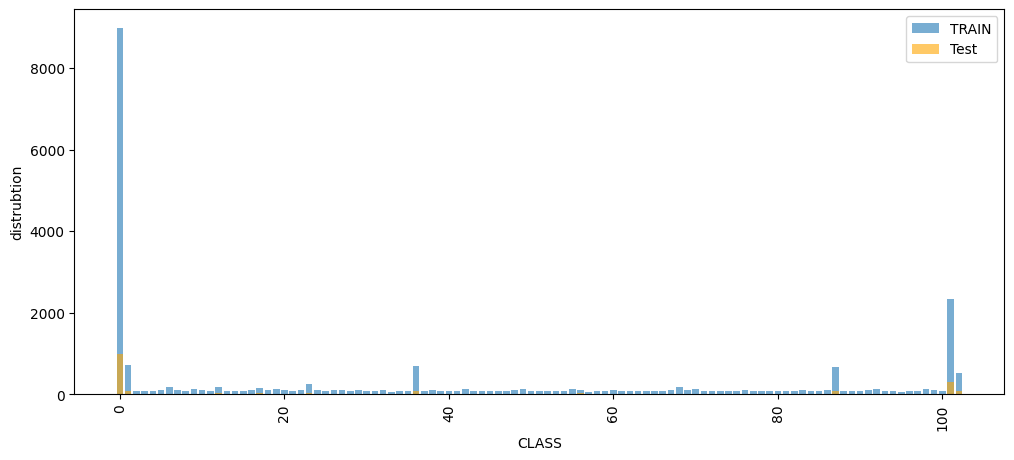

In [5]:
import json

with open("train_category_distribution.json", "r") as train_file:
    train_count = json.load(train_file)
    train_count = {int(k): v for k, v in train_count.items()}

with open("test_category_distribution.json", "r") as test_file:
    test_count = json.load(test_file)
    test_count = {int(k): v for k, v in test_count.items()}

print("TRAIN：", train_count)
print("TEST：", test_count)


def plot_category_distribution(train_count, test_count):
    train_categories, train_counts = zip(*train_count.items())
    test_categories, test_counts = zip(*test_count.items())

    plt.figure(figsize=(12, 5))
    plt.bar(train_categories, train_counts, label="TRAIN", alpha=0.6)
    plt.bar(test_categories, test_counts, label="Test", alpha=0.6, color='orange')
    plt.xticks(rotation=90)
    plt.xlabel("CLASS")
    plt.ylabel("distrubtion")
    plt.legend()
    plt.show()

plot_category_distribution(train_count, test_count)

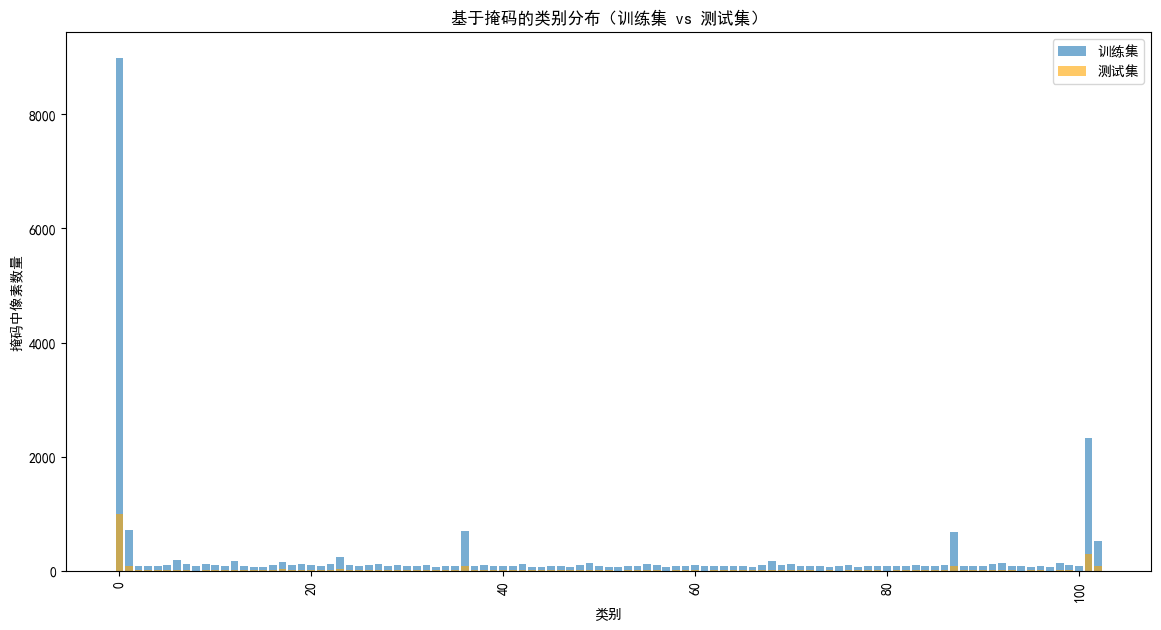

In [5]:
def plot_category_distribution(train_count, test_count):
    train_categories, train_counts = zip(*train_count.items())
    test_categories, test_counts = zip(*test_count.items())

    plt.figure(figsize=(14, 7))
    plt.bar(train_categories, train_counts, label="训练集", alpha=0.6)
    plt.bar(test_categories, test_counts, label="测试集", alpha=0.6, color='orange')
    plt.xticks(rotation=90)
    plt.xlabel("类别")
    plt.ylabel("掩码中像素数量")
    plt.title("基于掩码的类别分布（训练集 vs 测试集）")
    plt.legend()
    plt.show()

plot_category_distribution(train_count, test_count)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

import config
from model_utils import *
class SegNet(nn.Module):
    def __init__(self):
        super(SegNet, self).__init__()
        self.vgg16_bn = models.vgg16_bn(pretrained=True).features
        self.relu = nn.ReLU(inplace=True)
        self.index_MaxPool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.index_UnPool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        # net struct
        self.conv1_block = nn.Sequential(
            self.vgg16_bn[0],  # conv2d(3,64,(3,3))
            self.vgg16_bn[1],  # bn(64,eps=1e-05,momentum=0.1,affine=True)
            self.vgg16_bn[2],  # relu(in_place)
            self.vgg16_bn[3],  # conv2d(3,64,(3,3))
            self.vgg16_bn[4],  # bn(64,eps=1e-05,momentum=0.1,affine=True)
            self.vgg16_bn[5],  # relu(in_place)
        )
        self.conv2_block = nn.Sequential(
            self.vgg16_bn[7],
            self.vgg16_bn[8],
            self.vgg16_bn[9],
            self.vgg16_bn[10],
            self.vgg16_bn[11],
            self.vgg16_bn[12],
        )
        self.conv3_block = nn.Sequential(
            self.vgg16_bn[14],
            self.vgg16_bn[15],
            self.vgg16_bn[16],
            self.vgg16_bn[17],
            self.vgg16_bn[18],
            self.vgg16_bn[19],
            self.vgg16_bn[20],
            self.vgg16_bn[21],
            self.vgg16_bn[22],
        )
        self.conv4_block = nn.Sequential(
            self.vgg16_bn[24],
            self.vgg16_bn[25],
            self.vgg16_bn[26],
            self.vgg16_bn[27],
            self.vgg16_bn[28],
            self.vgg16_bn[29],
            self.vgg16_bn[30],
            self.vgg16_bn[31],
            self.vgg16_bn[32],
        )
        self.conv5_block = nn.Sequential(
            self.vgg16_bn[34],
            self.vgg16_bn[35],
            self.vgg16_bn[36],
            self.vgg16_bn[37],
            self.vgg16_bn[38],
            self.vgg16_bn[39],
            self.vgg16_bn[40],
            self.vgg16_bn[41],
            self.vgg16_bn[42],
        )

        self.upconv5_block = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
            self.relu,
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
            self.relu,
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
            self.relu,
        )
        self.upconv4_block = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
            self.relu,
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
            self.relu,
            nn.Conv2d(512, 256, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
            self.relu,
        )
        self.upconv3_block = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
            self.relu,
            nn.Conv2d(256, 256, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
            self.relu,
            nn.Conv2d(256, 128, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True),
            self.relu,
        )
        self.upconv2_block = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True),
            self.relu,
            nn.Conv2d(128, 64, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
            self.relu,
        )
        self.upconv1_block = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
            self.relu,
            nn.Conv2d(64, 103, kernel_size=(3, 3), padding=(1, 1)),
        )

    def forward(self, x):
        f1, idx1 = self.index_MaxPool(self.conv1_block(x))
        f2, idx2 = self.index_MaxPool(self.conv2_block(f1))
        f3, idx3 = self.index_MaxPool(self.conv3_block(f2))
        f4, idx4 = self.index_MaxPool(self.conv4_block(f3))
        f5, idx5 = self.index_MaxPool(self.conv5_block(f4))
        up6 = self.index_UnPool(f5, idx5)
        up5 = self.index_UnPool(self.upconv5_block(up6), idx4)
        up4 = self.index_UnPool(self.upconv4_block(up5), idx3)
        up3 = self.index_UnPool(self.upconv3_block(up4), idx2)
        up2 = self.index_UnPool(self.upconv2_block(up3), idx1)
        up1 = self.upconv1_block(up2)

        return F.log_softmax(up1, dim=1)


model = SegNet().to(device)

# 确保 class_weights 的长度与 num_classes（103）一致
class_weights = torch.zeros(103, dtype=torch.float).to(device)
for cls, count in train_count.items():
    if cls == 0:
        class_weights[cls] = 0.01  # 背景类别权重
    elif cls == 255:
        class_weights[cls] = 0.0  # 无效区域类别权重
    else:
        class_weights[cls] = 1 / np.sqrt(count)  # 其他类别权重



lossf = nn.CrossEntropyLoss(weight=class_weights, ignore_index=255)
optimizer = optim.Adam(model.parameters(),lr=0.003)
epochs_num = 10

In [8]:
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm

scaler = GradScaler()

def calculate_iou(pred, mask, num_classes):
    iou = []
    pred = pred.cpu().numpy()
    mask = mask.cpu().numpy()

    # 计算所有类别的 IoU，包括背景类0
    for cls in range(num_classes):
        pred_cls = pred == cls
        mask_cls = mask == cls
        intersection = np.logical_and(pred_cls, mask_cls).sum()
        union = np.logical_or(pred_cls, mask_cls).sum()
        if union == 0:
            iou.append(float('nan'))  # 避免分母为0时出错
        else:
            iou.append(intersection / union)

    return np.nanmean(iou)  # 返回所有类的平均 IoU

# 定义准确率计算函数，包括背景类0
def calculate_accuracy(pred, mask):
    pred = pred.cpu().numpy()
    mask = mask.cpu().numpy()
    correct = (pred == mask).sum()
    total = mask.size
    return correct / total

# 训练函数
def train(model, train_loader, test_loader, criterion, optimizer, device, epochs, num_classes):
    model.train()
    train_loss_history = []
    train_acc_history = []
    train_miou_history = []
    test_acc_history = []
    test_miou_history = []

    for epoch in range(epochs):
        running_loss = 0.0
        running_acc = 0.0
        running_miou = 0.0

        for images, masks, _ in tqdm(train_loader):
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()

            # 使用自动混合精度进行前向传播
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, masks)

            # 混合精度反向传播和优化
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

            # 计算预测
            preds = torch.argmax(outputs, dim=1)

            # 计算准确率和 IoU
            running_acc += calculate_accuracy(preds, masks)
            running_miou += calculate_iou(preds, masks, num_classes)

            # 释放无用的变量，并清理显存
            del outputs, loss, preds
            torch.cuda.empty_cache()

        # 计算每个 epoch 的平均 loss、accuracy 和 mIoU
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = running_acc / len(train_loader)
        epoch_miou = running_miou / len(train_loader)

        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)
        train_miou_history.append(epoch_miou)

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}, Train mIoU: {epoch_miou:.4f}")

        # 在每个 epoch 后保存模型
        torch.save(model.state_dict(), f"segnet_epoch_{epoch+1}.pth")

        # 在测试集上运行评估
        test_acc, test_miou = evaluate_model(model, test_loader, device, num_classes)
        test_acc_history.append(test_acc)
        test_miou_history.append(test_miou)
        print(f"Epoch [{epoch + 1}/{epochs}], Test Accuracy: {test_acc:.4f}, Test mIoU: {test_miou:.4f}")
        visualize_predictions(model,test_loader,device,num_samples=4)
    return train_loss_history, train_acc_history, train_miou_history, test_acc_history, test_miou_history

# 测试集上的评估函数
def evaluate_model(model, test_loader, device, num_classes):
    model.eval()
    total_acc = 0.0
    total_miou = 0.0
    num_batches = len(test_loader)

    with torch.no_grad():
        for images, masks, _ in test_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            # 计算准确率和 IoU
            total_acc += calculate_accuracy(preds, masks)
            total_miou += calculate_iou(preds, masks, num_classes)

    avg_acc = total_acc / num_batches
    avg_miou = total_miou / num_batches

    return avg_acc, avg_miou

def visualize_predictions(model, test_loader, device, num_samples=4):
    model.eval()
    with torch.no_grad():
        for images, masks, ids in test_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            # 打印 preds 的值
            print("Preds:", preds[0].cpu().numpy())  # 打印第一个样本的预测
            unique_values = torch.unique(preds).cpu().numpy()
            print("Unique predicted classes:", unique_values)  # 打印预测中包含的唯一类别

            fig, axes = plt.subplots(3, num_samples, figsize=(15, 8))
            for i in range(num_samples):
                if i < len(images):
                    # 显示原始图像
                    axes[0, i].imshow(images[i].cpu().permute(1, 2, 0))
                    axes[0, i].set_title(f"Test Image ID: {ids[i]}")
                    axes[0, i].axis('off')

                    # 显示真实掩码
                    axes[1, i].imshow(masks[i].cpu())
                    axes[1, i].set_title("Ground Truth")
                    axes[1, i].axis('off')

                    # 显示模型预测掩码
                    axes[2, i].imshow(preds[i].cpu())
                    axes[2, i].set_title("Predicted Mask")
                    axes[2, i].axis('off')

            plt.show()
            break

100%|██████████| 1000/1000 [19:11<00:00,  1.15s/it]


Epoch [1/10], Train Loss: 4.4276, Train Accuracy: 0.5060, Train mIoU: 0.0389
Epoch [1/10], Test Accuracy: 0.5597, Test mIoU: 0.0791
Preds: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Unique predicted classes: [0]


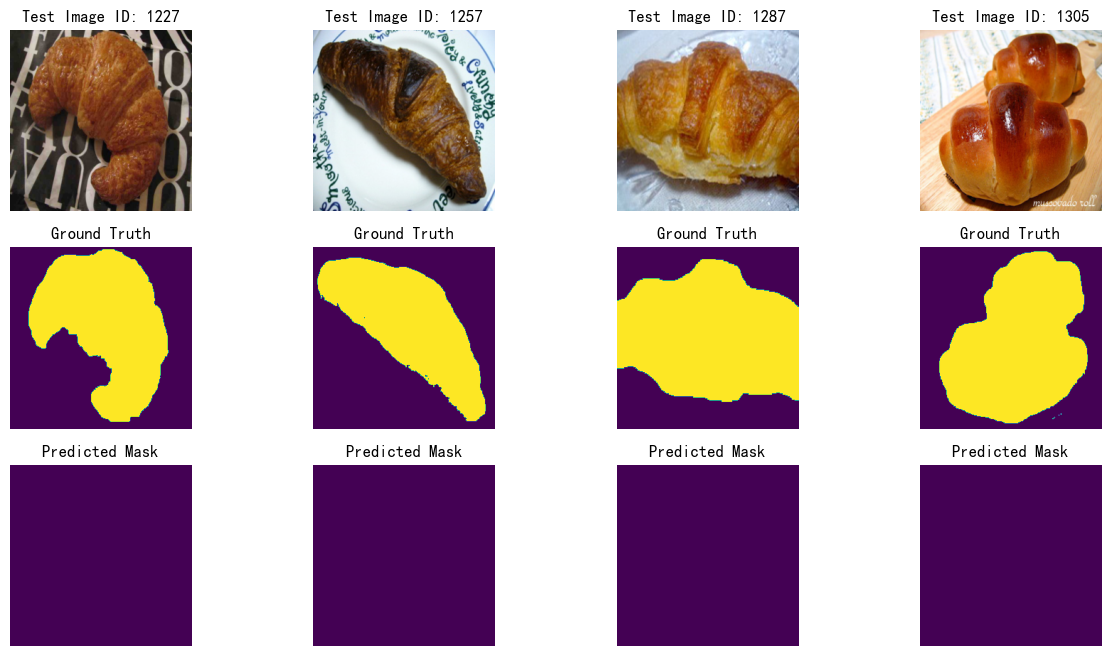

  4%|▍         | 38/1000 [00:40<16:55,  1.06s/it]


KeyboardInterrupt: 

In [9]:
num_classes = 103
train_loss_history, train_acc_history, train_miou_history, val_acc_history, val_miou_history = train(
    model, train_loader, test_loader, lossf, optimizer, device, epochs_num, num_classes
)

In [7]:
# 定义训练集总数的划分比例
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_small_loader = DataLoader(train_subset, batch_size=12, shuffle=True, pin_memory=True)
val_small_loader = DataLoader(val_subset, batch_size=12, shuffle=False, pin_memory=True)